# Why it’s time to stop processing satellite imagery on your laptop

## Haven’t moved to the cloud yet? Here is a good reason you should!

This Jupyter Notebook was written to accompany William Ray's [blog post](https://medium.com/sentinel-hub/tk-why-its-time-to-stop-processing-satellite-imagery-on-your-laptop-a09dbf8c72c0), and compares two methods to access and process satellite data to study a phenomenon occuring on the Earth's surface.

### Case study: harvesting

For this comparison exercise, we will run an example worklow designed to mimic a typical user-case in Remote Sensing. Based on a pair of Sentinel-2 images we will create a simple algorithm that detects crop-harvesting events. To do so, we will collect Sentinel-2 imagery for two cloud-free dates approximately 1 month apart during summer 2020. For each of the dates, we will extract [NDVI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/) and identify large decreases in the index between the the two dates. To reduce the chances of false-positives owing to plant senescence, we will compute the [BSI](https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data) and only consider harvested areas in locations where the BSI is above an empirical threshold on the second date.

_Note: the approach is for illustration purposes only and is not a robust method for crop harvest detection. The algorithm is used here to show typical band operations._

### Approaches

In a first step, we will consider a "traditional" approach consisting in:

- downloading the Sentinel-2 scenes covering the area of interest (AOI)

- opening the necessary bands (B04, B08, B11)

- cropping the bands to the AOI

- mosaicking the bands

- computing the NDVI and BSI indices

- performing band-wise operations

- filtering the data to reduce noise

- plotting the resulting map


In the second part of the notebook, we will obtain identical results by:

- running a Sentinel Hub request that returns directly the indices of interest

- filtering the data to reduce noise

- plotting the resulting map


### Summary statistics

The following table recapitulates the run times based on the two approaches.

|  | Traditional Workflow | Sentinel Hub Workflow |
|---|---|---|
| Lines of code (excluding imports) | ~170 | ~65 |
| Runtime | ~11 minutes | 5 seconds |
| Volume of data downloaded | 4.7 GB | 5.7MB |


This workflow was run on a Laptop with the following configuration:

- CPU: Intel Core i7-8650U (4 core, 8 threads)
- RAM: 16G
- Graphics: UHD Graphics 620
- Operating system: Ubuntu 20.04.2 LTS

At the time of the Sentinel-2 scenes download an internet speed test was performed, with the following results:

- Download: 165.22 Mbps
- Upload: 176 Mbps
- Latency: 45.2 ms

### How to run this notebook

We have provided a requirements file alongside this notebook for users that use Conda. To automatically install the required libraries, you can run the following command:

```
conda env create -f blogpostenv.yml

```

Alternatively if you have problems cloning the environment using the above, you can manually build the environment yourself using the following commands:

```
conda create --name blogpostenv python=3.6
conda activate blogpostenv
```

```
conda install -c conda-forge numpy scipy 
conda install -c conda-forge sentinelhub
conda install jupyter
pip install eodag
conda install geopandas matplotlib
conda install -c conda-forge folium
conda install -c conda-forge rasterio=1.2.6
```

In addition, you will need:

- A Creodias account (free) that can be created [here](https://portal.creodias.eu/register.php).

- A Sentinel Hub account (free trial available), that can be created [here](https://www.sentinel-hub.com/create_account/).

For safety purposes we recommend saving your credentials to the `creds.py` file (pre-filled) that is located in the same repository as this Jupyter Notebook. Simply fill in your creodias credentials to run the first part of this Notebook. For the second part, you will need to specify the Sentinel Hub client and secret: [this page](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/) and [this video](https://youtu.be/sX3w3Wd3FBw?t=556) will help you retrieve your credentials.


If you run into problems, don't hesitate to leave a message on our [forum](https://forum.sentinel-hub.com/).


## Summary

[Getting started: setup the Area of Interest](#getting_started)

[Part 1: Traditional workflow](#traditional_workflow)

[Part 2: Sentinel Hub workflow](#sh_workflow)

## Library imports 

In [1]:
# Downloading satellite images
from eodag import EODataAccessGateway
from eodag.utils import ProgressCallback
from eodag.plugins.crunch.filter_overlap import FilterOverlap

# Reading satellite imagery
import rasterio as rio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling


# Sentinel Hub services
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, Geometry)

# General utilities
from datetime import date, timedelta
import glob
from pathlib import Path
import tarfile
import requests
import numpy as np
from scipy.ndimage import morphology
import geopandas as gpd
import fiona

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import folium

# Import credentials
from creds import *

## Getting started: setup the Area of Interest <a id='getting_started'></a>

For the purpose of this comparison exercise, we will be extracting satellite data over three small municipalities located in the Charente-Maritime department in the Nouvelle-Aquitaine region of south-western France: Aulnay, Nuaillé-sur-Boutonne and Villemorin. 

The `data.gouv.fr` website is the "Open platform for French public data", and offers access to a variety of datasets including the administrative boundaries. Here we will use the "French communal administrative delimitation from OpenStreetMap" available [here](https://www.data.gouv.fr/en/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/). Instead of downloading the file, unzipping it and opening it with the `Geopandas` library, we will access it directly within this Jupyter Notebook.

An alternative source to the data has been supplied to mitigate the risk of the OpenStreetMap dataset being unavailable. If the first link does not work, the data can be fetched from `gregoiredavid`'s [Github repository](https://github.com/gregoiredavid/france-geojson): simply uncomment the second line with the variable `france_admin_url` in the following cell.

In [2]:
# Request the administrative boundaries as a bytes dataset.
france_admin_url = "https://www.data.gouv.fr/en/datasets/r/17062524-991f-4e13-9bf0-b410cc2216fd"
#france_admin_url = "https://github.com/gregoiredavid/france-geojson/raw/master/communes.geojson"
france_admin = requests.get(france_admin_url, stream=True)
france_admin_bytes = bytes(france_admin.content)

# Import administrative boundaries into a Geodataframe
with fiona.BytesCollection(france_admin_bytes) as f:
    crs = f.crs
    france_df = gpd.GeoDataFrame.from_features(f, crs=crs["init"])
    
# Clear variables
france_admin_bytes = None
france_admin = None

In [3]:
# Select the municipalities of interest based on their Insee code.
if "insee" in france_df.columns:
    municipalities = france_df[france_df['insee'].isin(["17024", "17268", "17473"])]
elif "code" in france_df.columns:
    municipalities = france_df[france_df['code'].isin(["17024", "17268", "17473"])]

In the following cell we will use `folium` to plot the three selected communal areas on an interactive map.

In [4]:
# Create a basemap
location_map = folium.Map(location=[municipalities.iloc[-1].geometry.centroid.y, 
                                    municipalities.iloc[-1].geometry.centroid.x],
                          zoom_start=12, tiles='cartodbpositron')

# Add polygons to map
geo_j = folium.GeoJson(data=municipalities.to_json())
geo_j.add_to(location_map)

# Plot
location_map

For the rest of the workflow, we will be working with the three municipalities as a single entity (to query data). In the following cell the geometries are merged.

In [5]:
aoi = municipalities.dissolve()

# Create a basemap
location_map_dissolved = folium.Map(location=[aoi.iloc[0].geometry.centroid.y, 
                                              aoi.iloc[0].geometry.centroid.x],
                                    zoom_start=12, tiles='cartodbpositron')

# Add polygon to map
geo_j = folium.GeoJson(data=aoi.to_json())
geo_j.add_to(location_map_dissolved)

# Plot
location_map_dissolved

# Part 1: Traditional workflow <a id='traditional_workflow'></a>

## Downloading and processing the images locally

To start, we will show how to run a traditional workflow. We will go through data discovery, download, then the processing and visualisation of the imagery.

### 1. Downloading the data

A typical approach to fetch Sentinel-2 imagery is to go through the [Copernicus Open Access Hub](https://scihub.copernicus.eu/). However, for the purposes of this analysis we want all the steps to be integrated within the Jupyter Notebook. To do so, potential solutions include using the Open Access Hub's [API service](https://scihub.copernicus.eu/twiki/do/view/SciHubWebPortal/APIHubDescription?TWIKISID=a63e87e9a4e5492957748ab5d7c65d8a) or making use of a Python library such as [Sentinelsat](https://sentinelsat.readthedocs.io/en/stable/). The problem with this approach is that images older than [30 days](https://github.com/sentinelsat/sentinelsat/issues/466) are stored as LTA, and need to be ordered asynchronously. This would make the workflow cumbersome and not easily scalable.

To access Sentinel-2 archives immediately, we can make use of the avalability of the data on the [DIAS platforms](https://www.copernicus.eu/en/access-data/dias). To make the ordering process even easier, we will use the [EODAG](https://eodag.readthedocs.io/en/stable/) python library. As mentioned in their documentation, EODAG allows "searching and downloading remotely sensed images while offering a unified API for data access regardless of the data provider".

For this example, we will be using EODAG to fetch Sentinel-2 L2A images from Creodias (see introduction on how to create an account and setup credentials for free).

In [6]:
# Set the directory where results will be stored
results_dir = "./data"

In [7]:
# Create an EODAG object
dag = EODataAccessGateway()

# Print the providers that offer access to Sentinel-2 L2A data
dag.available_providers("S2_MSI_L2A")

['astraea_eod',
 'aws_eos',
 'creodias',
 'earth_search',
 'mundi',
 'onda',
 'peps',
 'sobloo']

There are multiple options to access Sentinel-2 L2A data. As mentioned previously, we will set Creodias to be our provider.

In [8]:
dag.set_preferred_provider("creodias")

In the following cell, we set our credentials that are stored in `creds.py` as well as the output folder specified above.

In [9]:
overrides = {
            "download": {"outputs_prefix": results_dir},
            "auth": {"credentials": {"username": creodias_username, "password": creodias_password}},
        }
dag.providers_config["creodias"].update(overrides)

In the next cell, we will create a dictionnary that contains the search criteria for the two dates that we are interested in. The `productType` is set to `S2_MSI_L2A` to fetch Sentinel-2 L2A data, we set two dates (that we know are cloud-free over our AOI), and parse the geometry of our previously set AOI.

In [10]:
first_date = date(2020, 7 ,12)
second_date = date(2020, 8, 6)

date1_search_criteria = {
    "productType": "S2_MSI_L2A",
    "start": first_date,
    "end": first_date + timedelta(days=1),
    "geom": {"lonmin": aoi.iloc[0].geometry.bounds[0], "latmin": aoi.iloc[0].geometry.bounds[1],
             "lonmax": aoi.iloc[0].geometry.bounds[2], "latmax": aoi.iloc[0].geometry.bounds[3]}
}

date2_search_criteria = {
    "productType": "S2_MSI_L2A",
    "start": second_date,
    "end": second_date + timedelta(days=1),
    "geom": {"lonmin": aoi.iloc[0].geometry.bounds[0], "latmin": aoi.iloc[0].geometry.bounds[1],
             "lonmax": aoi.iloc[0].geometry.bounds[2], "latmax": aoi.iloc[0].geometry.bounds[3]}
}

In [11]:
# Run a request to search for the data based on the criteria set in the cell above.
all_products_date1 = dag.search_all(**date1_search_criteria, items_per_page=50)
all_products_date2 = dag.search_all(**date2_search_criteria, items_per_page=50)

print(f"Got a hand on a total number of {len(all_products_date1)} products for {first_date}, and {len(all_products_date2)} products for {second_date}.")

Got a hand on a total number of 4 products for 2020-07-12, and 4 products for 2020-08-06.


In the next steps, we will plot the products returned by the search in order to choose the relevant scenes to download.

The following function was written to create an interactive map based on different search results.

In [12]:
def create_search_result_map(lon, lat, zoom, search_results, extent):
    """Small utility to create an interactive map with folium
    that displays an extent in red and EO Producs in blue."""
    
    fmap = folium.Map([lat, lon], zoom_start=zoom)
    
    folium.GeoJson(
        extent,
        style_function=lambda x: dict(color="red")
    ).add_to(fmap)
    
    [folium.GeoJson(
        x
    ).add_child(folium.Popup(x.properties["title"])).add_to(fmap) for x in search_results]
    
    return fmap

First, we will plot all the search results for the first date.By clicking on the tiles in the interactive map, we can get information about the scene (based on its filename).

In [13]:
create_search_result_map(aoi.iloc[0].geometry.centroid.x, 
                         aoi.iloc[0].geometry.centroid.y,
                         8,
                         all_products_date1, aoi.iloc[0].geometry)

We can see that our AOI is covered by 4 Sentinel-2 tiles. However, we can achieve full coverage by selecting the two top tiles alone. By clicking on the map, we can determine that the tile names are `TX30TXS` and `T30TYS`. Therefore, we will only download those two tiles for both dates, by subsetting the search results.

In [14]:
# Get the two tiles for each date
filtered_products_date1 = [x for x in all_products_date1 if x.properties["title"].split("_")[5] in ["T30TXS", "T30TYS"]]
filtered_products_date2 = [x for x in all_products_date2 if x.properties["title"].split("_")[5] in ["T30TXS", "T30TYS"]]

Let's take a look at the list of results that we will download. We can also plot the selected tiles on the interactive map in green.

In [15]:
print(f"First date: \n {filtered_products_date1}")
print(f"Second date: \n {filtered_products_date2}")

First date: 
 [EOProduct(id=S2A_MSIL2A_20200712T105621_N0214_R094_T30TYS_20200712T133203, provider=creodias), EOProduct(id=S2A_MSIL2A_20200712T105621_N0214_R094_T30TXS_20200712T133203, provider=creodias)]
Second date: 
 [EOProduct(id=S2B_MSIL2A_20200806T105619_N0214_R094_T30TXS_20200806T131026, provider=creodias), EOProduct(id=S2B_MSIL2A_20200806T105619_N0214_R094_T30TYS_20200806T131026, provider=creodias)]


In [16]:
fmap = create_search_result_map(aoi.iloc[0].geometry.centroid.x, 
                         aoi.iloc[0].geometry.centroid.y,
                         8, all_products_date1, aoi.iloc[0].geometry)

# Create a layer that highlights the selected tiles in green
[folium.GeoJson(x, style_function=lambda x: dict(color="green")).add_to(fmap) for x in filtered_products_date1]
fmap

Finally we can download and extract the images for both dates.

In [17]:
products_date1 = dag.download_all(filtered_products_date1, extract=True)
products_date2 = dag.download_all(filtered_products_date2, extract=True)

Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

### 2. Process data

In the step below functions to process the raster files with Rasterio are defined.

In [18]:
def crop_rasters(filenames, aoi, nodata, output_path, nd=65535):
    """Crop a list of rasters based on a AOI and save the outputs."""
    output_files = []
    
    for f in filenames:
        with rio.open(f) as raster:
            
            # Get crs from profile and convert input aoi
            profile = raster.profile
            crop_bound = aoi.to_crs(profile["crs"])

            # Mask raster
            out_img, out_transform = mask(raster, shapes=crop_bound, crop=True, nodata=nd)

            # Save raster
            output_files.append(f"{output_path}/{Path(f).stem}_crop.tiff")
            write_raster(f"{output_path}/{Path(f).stem}_crop.tiff", out_img[0, :, :], profile["crs"],
                         out_transform, nd, driver='GTiff')

    return output_files  


def mosaic_rasters(filenames):
    """Mosaic several rasters."""
    to_mosaic = []
    crs = []
    nodata = []
    
    for file in filenames:
        src = rio.open(file, masked=True)
        nodata.append(src.nodata)
        to_mosaic.append(src)
        crs.append(src.profile["crs"])
        
    mosaic, transform = merge(to_mosaic)
    
    if not all(x==crs[0] for x in crs):
        raise ValueError("Not all files in the same projection!")
        
    if not all(x==nodata[0] for x in nodata):
        raise ValueError("Not all file have the same nodata mask!")
               
    return np.where(mosaic==nodata[0], np.nan, mosaic), transform, crs[0]


def rio_resample(method):
    """Return a rasterio resampling method based on a string."""
    
    resampling_methods = {"nearest": rio.enums.Resampling.nearest,
                          "bilinear": rio.enums.Resampling.nearest,
                          "cubic": rio.enums.Resampling.nearest,
                          "cubic_spline": rio.enums.Resampling.cubic_spline,
                          "lanczos": rio.enums.Resampling.lanczos,
                          "average": rio.enums.Resampling.average,
                          "mode": rio.enums.Resampling.mode,
                          "gauss": rio.enums.Resampling.gauss,
                          "max": rio.enums.Resampling.max,
                          "min": rio.enums.Resampling.min,
                          "med": rio.enums.Resampling.med,
                          "q1": rio.enums.Resampling.q1,
                          "q3": rio.enums.Resampling.q3,
                          "sum": rio.enums.Resampling.sum,
                          "rms": rio.enums.Resampling.rms,
                         }
    
    if method not in resampling_methods:
        raise ValueError("Wrong resampling method selected."
                         " See: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums."
                         "html#rasterio.enums.Resampling")
    
    return resampling_methods[method]


def resample_rasters(filenames, upscale_factor, output_path, method="nearest"):
    """Resample list of rasters."""
    output_files = []

    for file in filenames:
        src = rio.open(file)
        
        # resample data to target shape
        data = src.read(out_shape=(src.count, int(src.height * upscale_factor),
                                   int(src.width * upscale_factor)),
                        resampling=rio_resample(method))

        # scale image transform
        transform = src.transform * src.transform.scale((src.width / data.shape[-1]),
                                                        (src.height / data.shape[-2]))
        
        # Save rasters
        output_files.append(f"{output_path}/{Path(file).stem}_resampled.tiff")
        write_raster(f"{output_path}/{Path(file).stem}_resampled.tiff", data[0,:,:], src.profile["crs"], transform, 65535)
        
    return output_files


def reproject_raster(inpath, outpath, crs, method="nearest"):
    "Reproject a raster to a new coordinate system."
    
    dst_crs = f'EPSG:{crs}'
    
    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=rio_resample(method))
    

def write_raster(path, raster, crs, transform, nodata, driver='GTiff'):
    """Write a raster to a file."""
    
    with rio.open(path, 'w', driver=driver, height=raster.shape[0], width=raster.shape[1],
                       count=1, dtype=raster.dtype, crs=crs, transform=transform, nodata=nodata) as dst:
        dst.write(raster, 1)

#### Date 1

In a first step we will search for all the Band 4 and Band 8 files in the selected products covering our area of interest.

In [19]:
bands_t1 = glob.glob(f"{products_date1[0]}/**/*B0[4-8]_10m.jp2", recursive=True)
bands_t2 = glob.glob(f"{products_date1[1]}/**/*B0[4-8]_10m.jp2", recursive=True)
all_bands = bands_t1 + bands_t2

# Extract bands 4 and 8 paths and group them
bands_B04 = [x for x in all_bands if "B04" in x]
bands_B08 = [x for x in all_bands if "B08" in x]

To avoid opening and processing the entires scenes, we will crop the bands to our area of interest (AOI).

In [20]:
cropped_B04 = crop_rasters(bands_B04, aoi.geometry, 65535, results_dir)
cropped_B08 = crop_rasters(bands_B08, aoi.geometry, 65535, results_dir)

Since we have multiple files for each band, we mosaick the bands together.

In [21]:
mosaic_B04, trans_B04, crs_B04 = mosaic_rasters(cropped_B04)
mosaic_B08, trans_B08, crs_B08 = mosaic_rasters(cropped_B08)

Now we calculate the NDVI for the first mosaic.

In [22]:
ndvi_t1 = (mosaic_B08 - mosaic_B04) / (mosaic_B08 + mosaic_B04)

We can save this intermediate result to a file.

In [23]:
write_raster(f"{results_dir}/NDVI_date1.tif", ndvi_t1[0,:,:], crs_B04, trans_B04, -9999)

#### Date 2

For the second date, we need more bands because we want to compute NDVI and BSI. We start by filtering the bands of interest.

In [24]:
bands_t1 = glob.glob(f"{products_date2[0]}/**/*B[0-8][0-8]*.jp2", recursive=True)
bands_t2 = glob.glob(f"{products_date2[1]}/**/*B[0-8][0-8]*.jp2", recursive=True)
all_bands = bands_t1 + bands_t2

# Extract bands 4 and 8 paths and group them
bands_B02 = [x for x in all_bands if ("B02" in x) and ("10m" in x)]
bands_B04 = [x for x in all_bands if ("B04" in x) and ("10m" in x)]
bands_B08 = [x for x in all_bands if ("B08" in x) and ("10m" in x)]
bands_B11 = [x for x in all_bands if ("B11" in x) and ("20m" in x)]  # B11 at 20m resolution

Band 11 comes with a spatial resolution of 20m (see [documentation](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)). In order to perform band-wise operations with the other bands at a 10-meter resolution, we need to resample the band (by a factor of 2).

In [25]:
resampled_B11 = resample_rasters(bands_B11, 2, results_dir, method="nearest")

To avoid opening and processing the entires scenes, we will crop the bands to our area of interest (AOI).

In [26]:
cropped_B02 = crop_rasters(bands_B02, aoi.geometry, 65535, results_dir)
cropped_B04 = crop_rasters(bands_B04, aoi.geometry, 65535, results_dir)
cropped_B08 = crop_rasters(bands_B08, aoi.geometry, 65535, results_dir)
cropped_B11 = crop_rasters(resampled_B11, aoi.geometry, 65535, results_dir)

Since we have multiple files for each band, we mosaick the bands together.

In [27]:
mosaic_B02, trans_B02, crs_B02 = mosaic_rasters(cropped_B02)
mosaic_B04, trans_B04, crs_B04 = mosaic_rasters(cropped_B04)
mosaic_B08, trans_B08, crs_B08 = mosaic_rasters(cropped_B08)
mosaic_B11, trans_B11, crs_B11 = mosaic_rasters(cropped_B11)

Now we calculate NDVI and BSI for the second date.

In [28]:
ndvi_t2 = (mosaic_B08 - mosaic_B04) / (mosaic_B08 + mosaic_B04)
bsi_t2 = ((mosaic_B11 + mosaic_B04) - (mosaic_B08 + mosaic_B02)) / ((mosaic_B11 + mosaic_B04) + (mosaic_B08 + mosaic_B02))

We can save this intermediate result to a file.

In [29]:
write_raster(f"{results_dir}/NDVI_date2.tif", ndvi_t2[0,:,:], crs_B04, trans_B04, -9999)
write_raster(f"{results_dir}/BSI_date2.tif", bsi_t2[0,:,:], crs_B04, trans_B04, -9999)

In the last step of the calculations, we compute the harvested product based on empirical products. We consider a field to be harvested if the decrese in NDVI between the two dates is larger than 0.25, and to remove false positives due to plant senescence, we only consider an area to be harvested if the BSI is larger than 0.15.

In [30]:
harvested = np.where((ndvi_t1 - ndvi_t2 > 0.25) & (bsi_t2 > 0.15), 1, 0)

### 3. Plot data

In the next cells, we will plot the different products obtained from our processing chain.

We will start with the NDVI product for the first date.

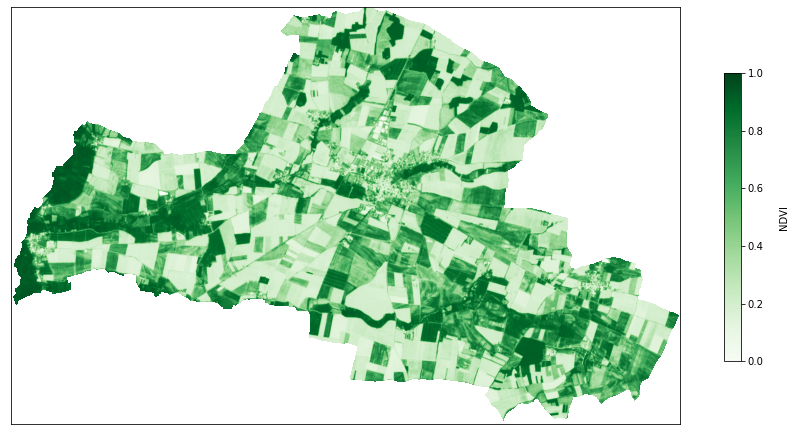

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(ndvi_t1[0,:,:], cmap='Greens', vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('NDVI', rotation=90)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Next, we will plot the NDVI product for the second date.

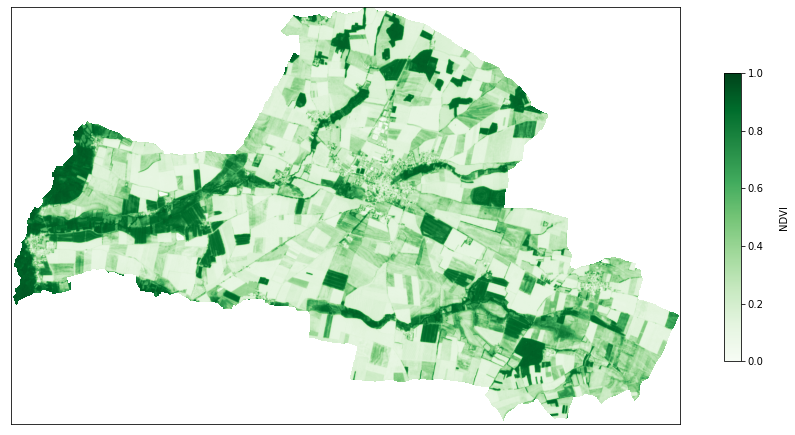

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(ndvi_t2[0,:,:], cmap='Greens', vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('NDVI', rotation=90)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In the following cell we will plot the BSI for the second date.

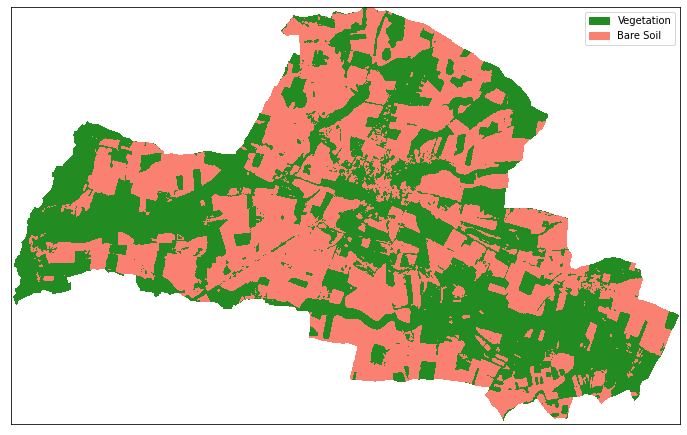

In [33]:
cmap_bsi = colors.ListedColormap(['forestgreen', 'salmon'])
bounds_bsi = [-10,0.15,10]
norm_bsi = colors.BoundaryNorm(bounds_bsi, cmap_bsi.N)

fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(bsi_t2[0, :, :], cmap=cmap_bsi, norm=norm_bsi)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='forestgreen', label='Vegetation'),
                     mpatches.Patch(color='salmon', label='Bare Soil')])

plt.show()

Next, we plot the "harvested" product.

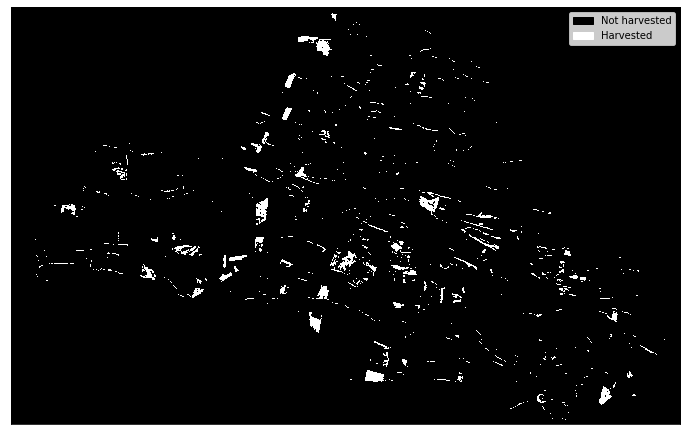

In [34]:
cmap_harvested = colors.ListedColormap(['black', 'white'])
bounds_harvested = [0,0.5,1]
norm_harvested = colors.BoundaryNorm(bounds_harvested, cmap_harvested.N)

fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(harvested[0, :, :], cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='black', label='Not harvested'),
                     mpatches.Patch(color='white', label='Harvested')])

plt.show()

As we can see in the figure above, the resulting layer is quite noisy, with many very small patches (a few pixels) being identified as harvested areas. As we are only interested in identifying the fields that were harvested, we can clean the dataset by applying a binary opening function. A binary opening is the dilation of the erosion of the image, which removes the smaller clumps of pixels. 

In [35]:
harvested_cleaned = morphology.binary_opening(harvested[0,:,:], structure=np.ones((5,5))).astype(np.int8)

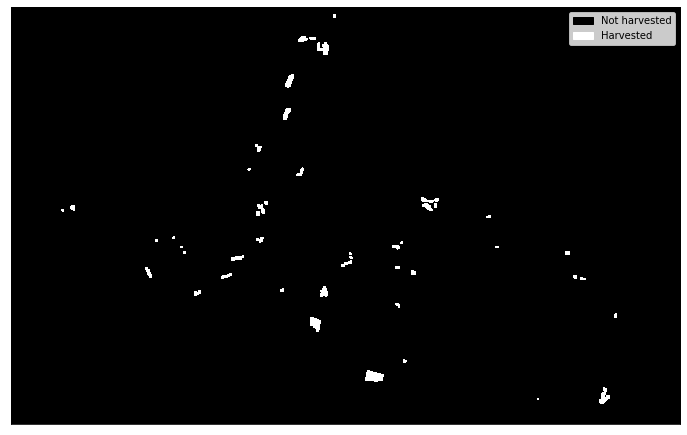

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(harvested_cleaned, cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='black', label='Not harvested'),
                     mpatches.Patch(color='white', label='Harvested')])

plt.show()

You can try different methods to clean the dataset. Once we are satisfied with the results, we can write them to a file.

In [37]:
write_raster(f"{results_dir}/harvested_fields.tif", harvested_cleaned.astype('uint8'), crs_B04, trans_B04, 0)

To be able to plot the data on an interactive map, we will reproject the resulting geotiff to `EPSG:4326`.

In [38]:
# Reproject the raster
reproject_raster(f"{results_dir}/harvested_fields.tif",
                 f"{results_dir}/harvested_fields_4326.tif", 4326, method="nearest")

# Open the reprojected raster
harvested_4326 = rio.open(f"{results_dir}/harvested_fields_4326.tif")

# Plot on the interactive map
fmap = folium.Map([aoi.iloc[0].geometry.centroid.y, 
                   aoi.iloc[0].geometry.centroid.x],
                   zoom_start=13, tiles='cartodbpositron')

folium.raster_layers.ImageOverlay(
    image=harvested_4326.read(1),
    bounds=[[harvested_4326.bounds.bottom, harvested_4326.bounds.left], 
            [harvested_4326.bounds.top, harvested_4326.bounds.right]],
    colormap=lambda x: (1, 0, 0, x)
    ).add_to(fmap)

fmap

In [39]:
# Don't forget to close the opened raster
harvested_4326.close()

# Part 2: Sentinel Hub workflow <a id='sh_workflow'></a>

In contrast to the traditional methods only few steps need to be made using the Sentinel Hub API. This is because Sentinel Hub automatically deals with the data processing steps like tiling, mosaicking. Therefore, rather than download 4 separate scenes like previously, we only access the pixels that we actually require.

In the following cells, we will use [Sentinelhub-py](https://sentinelhub-py.readthedocs.io/en/latest/) to access the API. For this you will need a Sentinel Hub account (see introduction) and set your credentials in `creds.py`. 

### 1. Authentication

In [40]:
# Set up configuration tool
config = SHConfig()

config.sh_client_id = sh_client
config.sh_client_secret = sh_secret

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

### 2. Convert AOI to a Sentinel Hub object

In [41]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

### 3. Write an Evalscript

An [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/) (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. It is a required part of any process, batch processing or OGC request.

In the following Evalscript we will perform all the processing steps that we performed in the "tradionnal" approach.

In [42]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B04", "B08", "B11"],
    output: [{id: "ndvi_t1", bands: 1, sampleType: "FLOAT32"},
             {id: "ndvi_t2", bands: 1, sampleType: "FLOAT32"},
             {id: "bsi_t2", bands: 1, sampleType: "FLOAT32"},
             {id: "harvested", bands: 1, sampleType: "UINT8"}],
    mosaicking: "ORBIT"
  };
}

function preProcessScenes (collections) {
    var allowedDates = ["2020-07-12", "2020-08-06"]; //before and after Knysna fires
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    });
    return collections;
}

function evaluatePixel(samples, scenes) {
  // Compute ndvi for all dates
  var ndvi = [];
  for (i=0; i<samples.length; i++){
    ndvi.push((samples[i].B08 - samples[i].B04) / (samples[i].B08 + samples[i].B04));
  }
  
  // Compute bsi for latest date
  var bsi = ((samples[0].B11 + samples[0].B04) - (samples[0].B08 + samples[0].B02)) / ((samples[0].B11 + samples[0].B04) + (samples[0].B08 + samples[0].B02));

  // Compute harvested map
  var harvested = ((ndvi[1] - ndvi[0] > 0.25 && bsi > 0.15)) ? 1 : 0;
    
  return {
    "ndvi_t1": [ndvi[1]],
    "ndvi_t2": [ndvi[0]],
    "bsi_t2": [bsi],
    "harvested": [harvested]
  };
}
"""

### 4. Build the request

In the following cell, we set all the input parameters for our requests:

- the evalscript

- the AOI

- the sensor to be queried 

- the time interval covering the two dates

- the output rasters to be returned

- the resolution of the products

- the folder where the data will be saved

- the configuration object (containing credentials)


In [43]:
request = SentinelHubRequest(evalscript=evalscript,
                             geometry=full_geometry,
                             input_data = [SentinelHubRequest.input_data(
                                 data_collection=DataCollection.SENTINEL2_L2A,
                                 time_interval=('2020-07-12', '2020-08-06'),)],
                             responses=[SentinelHubRequest.output_response('ndvi_t1', MimeType.TIFF),
                                        SentinelHubRequest.output_response('ndvi_t2', MimeType.TIFF),
                                        SentinelHubRequest.output_response('bsi_t2', MimeType.TIFF),
                                        SentinelHubRequest.output_response('harvested', MimeType.TIFF),],
                             resolution=(10,10),
                             data_folder=results_dir,
                             config=config)

### 5. Run the request

In [54]:
sh_request = request.get_data(save_data=True)

### 6. Plot the results

In the next cells, we will plot the different products obtained from our Sentinel Hub request.

We will start with the NDVI product for the first date.

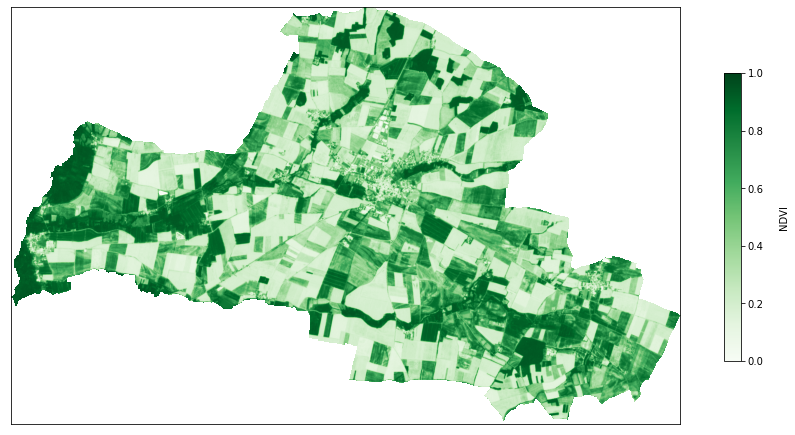

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(sh_request[0]['ndvi_t1.tif'], cmap='Greens', vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('NDVI', rotation=90)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Next, we will plot the NDVI product for the second date.

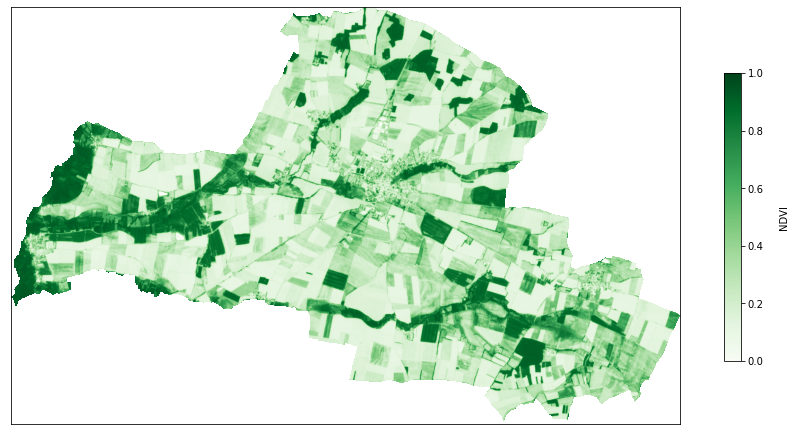

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(sh_request[0]['ndvi_t2.tif'], cmap='Greens', vmin=0, vmax=1)
cax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('NDVI', rotation=90)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In the following cell we will plot the BSI for the second date.

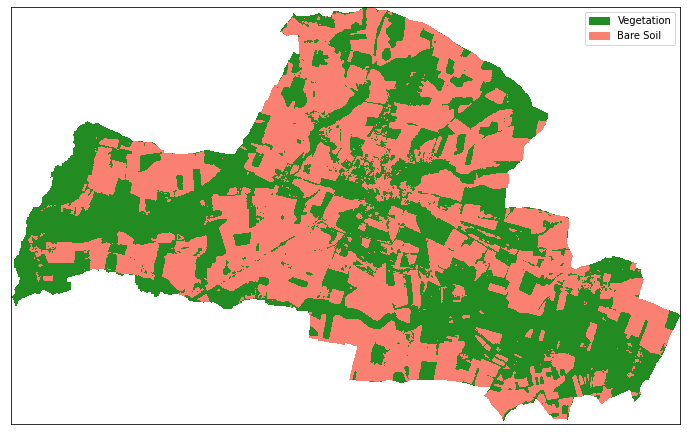

In [47]:
cmap_bsi = colors.ListedColormap(['forestgreen', 'salmon'])
bounds_bsi = [-10,0.15,10]
norm_bsi = colors.BoundaryNorm(bounds_bsi, cmap_bsi.N)

fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(sh_request[0]['bsi_t2.tif'], cmap=cmap_bsi, norm=norm_bsi)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='forestgreen', label='Vegetation'),
                     mpatches.Patch(color='salmon', label='Bare Soil')])

plt.show()

Next, we plot the "harvested" product.

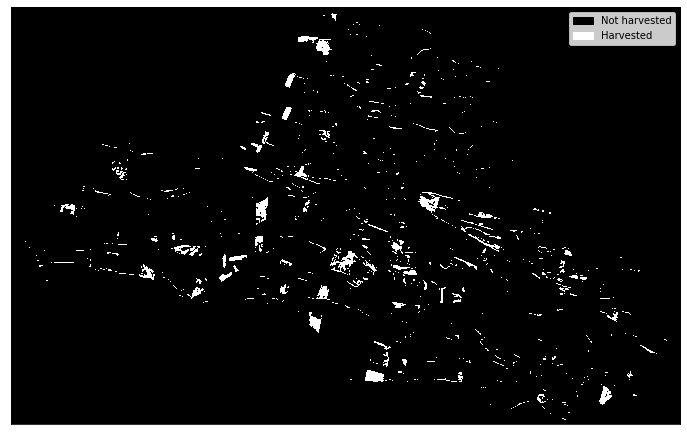

In [48]:
cmap_harvested = colors.ListedColormap(['black', 'white'])
bounds_harvested = [0,0.5,1]
norm_harvested = colors.BoundaryNorm(bounds_harvested, cmap_harvested.N)

fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(sh_request[0]['harvested.tif'], cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='black', label='Not harvested'),
                     mpatches.Patch(color='white', label='Harvested')])

plt.show()

#### Clean up the harvest map

One of the limitations of Sentinel Hub services is that it fumctions on a per-pixel basis. Therefore to perform a morphological operation on the results we will open the raster and apply the last step on the downloaded file.

The first step consists in decompressing the `tar` file returned by the service.

In [49]:
results_tar = tarfile.open(f"{request.data_folder}/{request.get_filename_list()[0]}")
results_tar.extractall(f"{results_dir}/sh_results")
results_tar.close()

We then open the raster with `rasterio` and clean the data as we did in the "traditional" approach. We save the output, as well as the reprojected version to be able to plot the data interactively.

In [50]:
sh_harvested = rio.open(f"{results_dir}/sh_results/harvested.tif")

# Clean up dataset
sh_harvested_cleaned = morphology.binary_opening(sh_harvested.read(1), structure=np.ones((5,5))).astype(np.int8)

# Save the output
write_raster(f"{results_dir}/sh_results/harvested_fields.tif", sh_harvested_cleaned.astype('uint8'), sh_harvested.crs, sh_harvested.transform, 0)

# Reproject to EPSG 4326
reproject_raster(f"{results_dir}/sh_results/harvested_fields.tif",
                 f"{results_dir}/sh_results/harvested_fields_4326.tif", 4326, method="nearest")

sh_harvested.close()

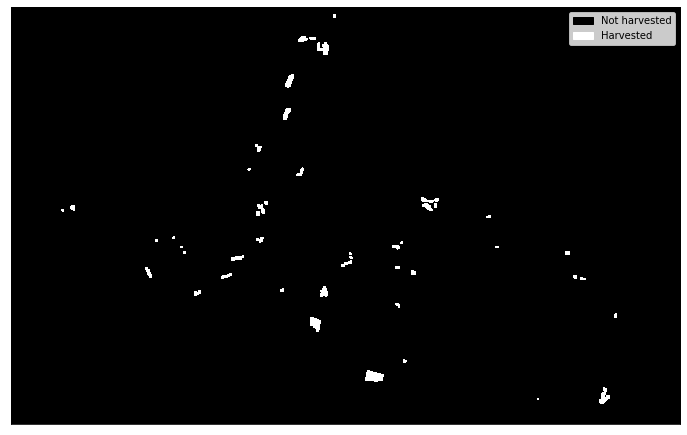

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(harvested_cleaned, cmap=cmap_harvested, norm=norm_harvested)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles = [mpatches.Patch(color='black', label='Not harvested'),
                     mpatches.Patch(color='white', label='Harvested')])

plt.show()

We now plot the data on an interactive map.

In [52]:
# Open reprojected raster
sh_harvested_4326 = rio.open(f"{results_dir}/sh_results/harvested_fields_4326.tif")

# Create map
fmap = folium.Map([aoi.iloc[0].geometry.centroid.y, 
                   aoi.iloc[0].geometry.centroid.x],
                   zoom_start=13,tiles='cartodbpositron')

folium.raster_layers.ImageOverlay(
    image=sh_harvested_4326.read(1),
    bounds=[[sh_harvested_4326.bounds.bottom, sh_harvested_4326.bounds.left], 
            [sh_harvested_4326.bounds.top, sh_harvested_4326.bounds.right]],
    colormap=lambda x: (1, 0, 0, x)
    ).add_to(fmap)

fmap

In [53]:
# Close dataset
sh_harvested_4326.close()

## Conclusion 

After running this Jupyter Notebook we are certain that you will want to test Sentinel Hub services for your own workflow. Don't hesistate to go through our [API documentation](https://docs.sentinel-hub.com/api/latest/) or the Python package [documentation](https://sentinelhub-py.readthedocs.io/en/latest/). If you still have questions or want to show off your algorithm, make sure you pop by the [Forum](https://forum.sentinel-hub.com/).